In [23]:
import os
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import itertools
import seaborn as sns
from matplotlib.patches import Patch

In [24]:
data = pq.read_table("Master_labeled_ST_FINAL.parquet").to_pandas()
data['sports'] = np.where(data['predicted_label'] == 'non_sport', 0, 1)
data['olympic'] = np.where(data['predicted_label'] == 'olympic', 1, 0)

In [25]:
data.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,...,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,country_code,predicted_label,predicted_confidence,sports,olympic
0,oO4r2G1M4pM,Meine besten und schlechtesten Podcasts bisher?!,2023-05-03T16:21:01Z,UCa2ikhDgZNB01WGmvI8784A,Tim Gabel,22,2023-05-04T00:00:00Z,Tim Gabel|Tim Gabel Shorts|Shorts|Tim Gabel Cl...,64096,6151,...,327,https://i.ytimg.com/vi/oO4r2G1M4pM/default.jpg,False,False,Werbung | OLAKALA CC Halfzip und Elysium Cardi...,DE,non_sport,0.995812,0,0
1,HPr2rMwWg-M,Alle Messungen falsch? Krise der Kosmologie Te...,2023-05-03T13:00:18Z,UC5E9-r42JlymhLPnDv2wHuA,Terra X Lesch & Co,28,2023-05-04T00:00:00Z,terra x lesch & co.|terra x|harald lesch|ZDF|T...,118496,4397,...,354,https://i.ytimg.com/vi/HPr2rMwWg-M/default.jpg,False,False,Das Universum expandiert beschleunigt. So weit...,DE,non_sport,0.667791,0,0
2,sQr-kcMc7zo,Till Reiners: Wer ist alles schlecht in seinem...,2023-05-03T16:00:38Z,UCCdKkuyDe0rt950_fF3lAig,ZDF Comedy,23,2023-05-04T00:00:00Z,till reiners zdf comedy|till reiners comedy|zd...,51503,1722,...,34,https://i.ytimg.com/vi/sQr-kcMc7zo/default.jpg,False,False,"Till Reiners beobachtet, dass man mit zunehmen...",DE,non_sport,0.967978,0,0
3,Cr3fcxtL6mk,Jetzt kommt alles raus! Meine Schul-Sünden wer...,2023-05-02T13:00:14Z,UC5iYuXSliCgk_mtUJa25eoQ,MATTIN Live,24,2023-05-04T00:00:00Z,survival mattin|survival mattin bunker|surviva...,254549,19810,...,902,https://i.ytimg.com/vi/Cr3fcxtL6mk/default.jpg,False,False,Jetzt kommt alles raus! Meine Schul-Sünden wer...,DE,other_sport,0.764602,1,0
4,gSRzpimk4c0,#ThoMats Dosenschießen – Thomas Müller und Mat...,2023-05-03T13:30:10Z,UCIn7wtUMkEvDCnLvT15V6aw,Thomas Müller,17,2023-05-04T00:00:00Z,Thomas Müller|Thomas Mueller|Mats Hummels|Thom...,51974,2953,...,116,https://i.ytimg.com/vi/gSRzpimk4c0/default.jpg,False,False,Der Kampf um die Meisterschaft ist im vollen G...,DE,other_sport,0.997490,1,0


In [26]:
data['predicted_label'].value_counts(normalize = True)

predicted_label
non_sport      0.680861
other_sport    0.317710
olympic        0.001429
Name: proportion, dtype: float64

In [27]:
data['country_code'].value_counts()

country_code
GB    268791
BR    268790
FR    268788
US    268787
JP    268778
CA    268742
DE    268736
MX    268598
KR    265754
IN    251277
RU    238637
Name: count, dtype: int64

The average video is on trending for over 5 days (it's a little more than dividing the 2nd number by the first because not all videos trending on day 1 of the data entered on that day)

In [28]:
#number of videos trending with no duplicates globally - not used in our analysis
print(len(data['video_id'].unique()))
#number of videos trending with no duplicates within country
print(data[['country_code', 'video_id']].drop_duplicates().shape[0])
#number of videos trending across all day including duplicates
print(len(data['video_id']))

488876
597669
2905678


In [29]:
def clean_date(df, col):
    df['date_clean'] = pd.to_datetime(df[col]).dt.tz_localize(None) #strip timezone
    df['date_clean'] = df['date_clean'].dt.normalize() # sets time to 00:00:00

In [30]:
def create_aggregated_data(data_raw, duplicates = False, date_type = "published"):
    """
    duplicates: whether to keep all rows as opposed to only a video's first appearance on trending
    date_type: which column to use to assign dates to videos, either the date it trends or the date it is published
    """

    data_raw = data_raw.copy()

    if(date_type == "published"):
        clean_date(data_raw, 'publishedAt')
    elif(date_type == "trending"):
        clean_date(data_raw, 'trending_date')

    if(not duplicates):
       #first trending appearance per video in each country
        data_raw = data_raw.loc[ #experimental
            data_raw.groupby(['video_id', 'country_code'])['date_clean'].idxmin()
        ].copy()

        if(date_type == "trending"):
            data_raw = (data_raw
                    .groupby("country_code", group_keys=False)
                    .apply(lambda df: df.iloc[10:])
            )#drop first 10 days
        elif(date_type == "published"):
            #earliest observed date (globally)
            global_min_date = data_raw["date_clean"].min()
            # drop observations within 14 days of earliest published video that trended
            data_raw = data_raw[data_raw["date_clean"] > global_min_date + pd.Timedelta(days=14)]
    
    data_grouped = (
        data_raw.groupby(['country_code', 'date_clean'])
        .agg(
            videos=('predicted_label', 'size'),
            sports_videos=('sports', 'sum'),
            olympic_videos = ('olympic', 'sum')
        ).reset_index()
    )
    return(data_grouped)

In [31]:
#data can be aggregated in 4 ways using the duplicates and publishedAt arguments


#Of all the videos published on a certain day that trended, how many were sports related?
date_type = "published"
dupes = False
#this is the specification we use; the results for the others are in the appendix of our slides

#Of all the videos that trended which were published on a given day, how many were sports related?
#date_type = "published"
#dupes = True

#Of all the videos trending on a given day, how many were sports related?
#date_type = "trending"
#dupes = True

#Of all the videos that first trended on a given day, how many were sports related?
#date_type = "trending"
#dupes = False

data_grouped = create_aggregated_data(data, dupes, date_type)

data_grouped['month'] = data_grouped['date_clean'].dt.month
data_grouped["date_num"] = (data_grouped["date_clean"] - data_grouped["date_clean"].min()).dt.days
data_grouped['sports_pct'] = data_grouped['sports_videos'] / data_grouped['videos']
data_grouped['olympic_pct'] = data_grouped['olympic_videos'] / data_grouped['videos']


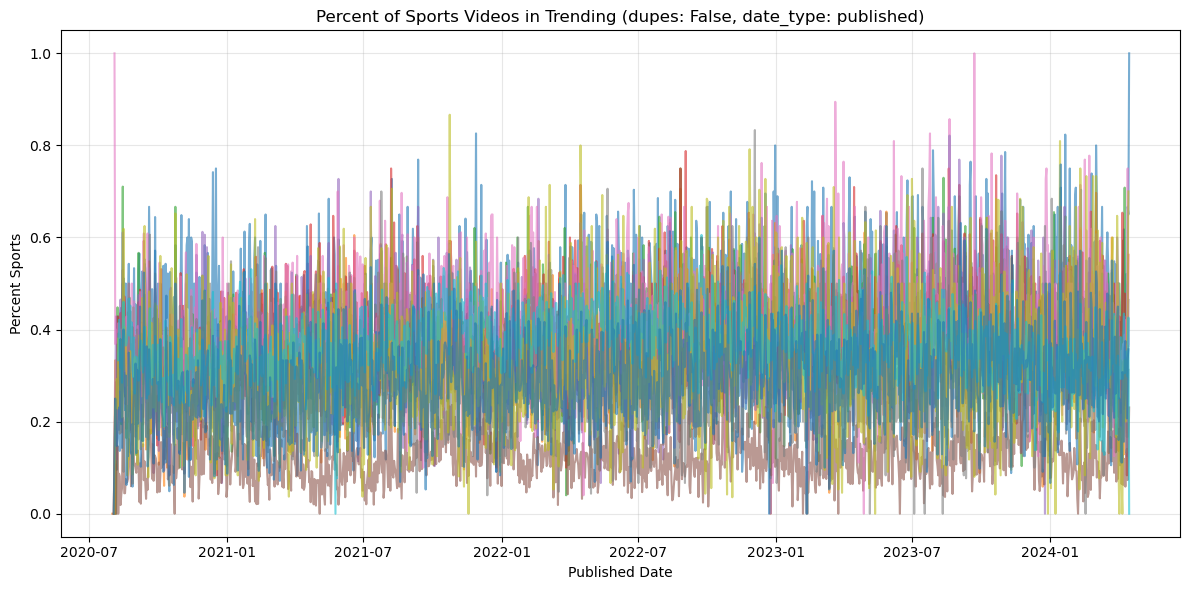

In [32]:
plt.figure(figsize=(12, 6))

# Plot one line per country
for country, group_df in data_grouped.groupby("country_code"):
    plt.plot(group_df["date_clean"], group_df["sports_pct"], alpha=0.6)

plt.title("Percent of Sports Videos in Trending (dupes: " + str(dupes) + ", date_type: " + date_type + ")")
plt.xlabel("Published Date" if date_type == "published" "" else "Trending Date")
plt.ylabel("Percent Sports")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

There are spikes in Olympics-related videos during the Olympics, but not as big as we might expect. Also, lots of Olympics-related videos far from an Olympics. We judged that our constructed Olympics label is too noisy to use.

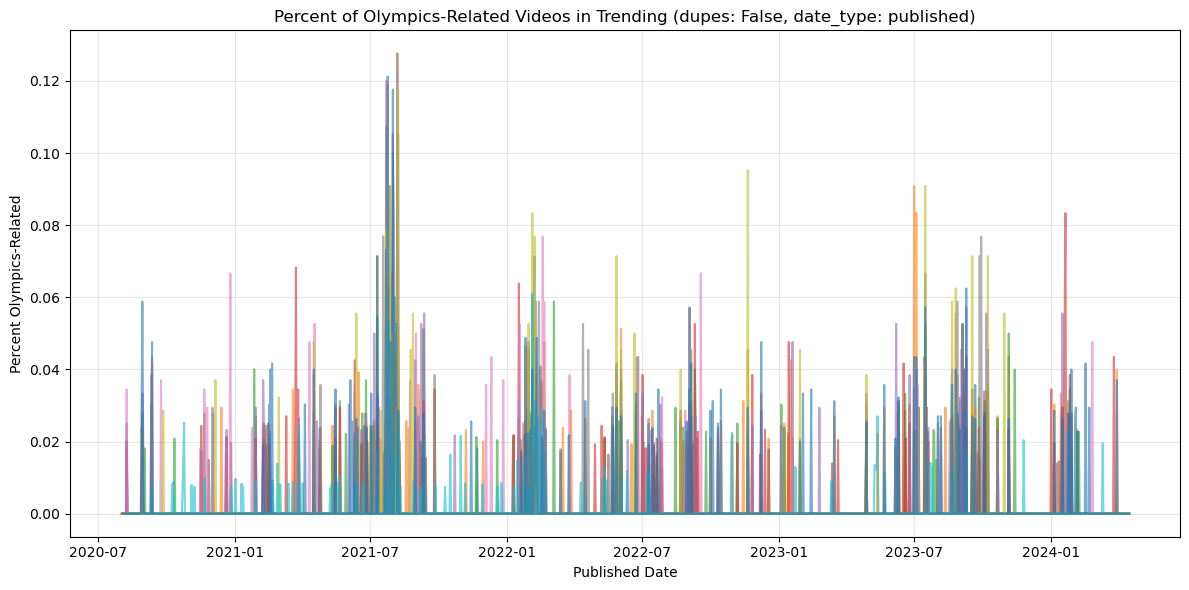

In [33]:
plt.figure(figsize=(12, 6))

# Plot one line per country
for country, group_df in data_grouped.groupby("country_code"):
    plt.plot(group_df["date_clean"], group_df["olympic_pct"], alpha=0.6)

plt.title("Percent of Olympics-Related Videos in Trending (dupes: " + str(dupes) + ", date_type: " + date_type + ")")
plt.xlabel("Published Date" if date_type == "published" "" else "Trending Date")
plt.ylabel("Percent Olympics-Related")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [34]:
import kagglehub #Kaggle API

summer_path = kagglehub.dataset_download("piterfm/tokyo-2020-olympics")
winter_path = kagglehub.dataset_download("piterfm/beijing-2022-olympics")

In [35]:
os.listdir(summer_path)

['athletes.csv',
 'technical_officials.csv',
 'medals_total.csv',
 'coaches.csv',
 'medals.csv']

In [36]:
summer_medals = pd.read_csv(os.path.join(summer_path,'medals.csv'))
winter_medals = pd.read_csv(os.path.join(winter_path,'medals.csv'))

In [37]:
print(summer_medals['country_code'].unique())
print(data_grouped['country_code'].unique())
#need to crosswalk over from 2 letter labels to 3

['KOR' 'NED' 'MEX' 'ECU' 'BEL' 'SLO' 'HUN' 'ITA' 'CHN' 'ROU' 'EST' 'JPN'
 'TPE' 'FRA' 'KAZ' 'KOS' 'UKR' 'MGL' 'IRI' 'SRB' 'ROC' 'SUI' 'TUN' 'THA'
 'ESP' 'ISR' 'IND' 'INA' 'GER' 'AUT' 'CAN' 'USA' 'GEO' 'BRA' 'GBR' 'BUL'
 'AUS' 'UZB' 'TUR' 'COL' 'CZE' 'HKG' 'DEN' 'KUW' 'JOR' 'CRO' 'EGY' 'CIV'
 'NOR' 'NZL' 'PHI' 'RSA' 'MKD' 'CUB' 'BER' 'TKM' 'LAT' 'IRL' 'POL' 'FIJ'
 'ARG' 'VEN' 'POR' 'SVK' 'SMR' 'FIN' 'ETH' 'UGA' 'AZE' 'GRE' 'DOM' 'SWE'
 'JAM' 'MAS' 'BLR' 'QAT' 'ARM' 'MAR' 'KEN' 'PUR' 'NAM' 'NGR' 'GHA' 'KGZ'
 'SYR' 'BAH' 'GRN' 'BUR' 'LTU' 'BOT' 'BRN' 'MDA' 'KSA']
['BR' 'CA' 'DE' 'FR' 'GB' 'IN' 'JP' 'KR' 'MX' 'RU' 'US']


In [38]:
iso2_to_iso3 = {
    "DE": "GER",
    "FR": "FRA",
    "GB": "GBR",
    "IN": "IND",
    "JP": "JPN",
    "KR": "KOR",
    "CA": "CAN",
    "BR": "BRA",
    "US": "USA",
    "MX": "MEX",
    "RU": "RUS" 
}

data_grouped['country_code_iso3'] = data_grouped['country_code'].map(iso2_to_iso3)

#Russian Olympic Committee
summer_medals['country_code_iso3'] = summer_medals['country_code'].replace({'ROC': 'RUS'})
winter_medals['country_code_iso3'] = winter_medals['country_code'].replace({'ROC': 'RUS'})

In [39]:
clean_date(summer_medals, 'medal_date')
clean_date(winter_medals, 'medal_date')

#these are based on when medals were won not opening and closing ceremonies
summer_min = summer_medals['date_clean'].min()
summer_max = summer_medals['date_clean'].max()

winter_min = winter_medals['date_clean'].min()
winter_max = winter_medals['date_clean'].max()

In [40]:
#creates dummy variables for the weeks before and after the Olympics and one for the time between the first and last medals
def create_week_window(df, start_date, end_date, weeks_before=1, weeks_after=3, prefix='summer'):
    """
    weeks_before: number of weeks prior to start_date to create dummy
    weeks_after: number of weeks after end_date to create dummy
    prefix: string to label the dummy columns
    """
    df = df.copy()
    
    #before
    for w in range(1, weeks_before + 1):
        col = f'{prefix}_week_minus_{w}'
        df[col] = ((df['date_clean'] >= (start_date - pd.Timedelta(weeks=w))) &
                   (df['date_clean'] < start_date)).astype(int)
    
    #during
    df[f'{prefix}_during'] = ((df['date_clean'] >= start_date) &
                              (df['date_clean'] <= end_date)).astype(int)
    
    #after
    for w in range(1, weeks_after+ 1):
        col = f'{prefix}_week_plus_{w}'
        df[col] = ((df['date_clean'] > end_date) &
                   (df['date_clean'] <= end_date + pd.Timedelta(weeks=w))).astype(int)
    
    return df

# Apply for Summer Olympics
data_grouped = create_week_window(data_grouped, summer_min, summer_max, prefix='summer')

# Apply for Winter Olympics
data_grouped = create_week_window(data_grouped, winter_min, winter_max, prefix='winter')

data_grouped['olympic_period'] = data_grouped['summer_during'] + data_grouped['winter_during']


In [41]:
medals = pd.concat([summer_medals, winter_medals], ignore_index=True)
medals['gold']   = (medals['medal_code'] == 1).astype(int)
medals['silver'] = (medals['medal_code'] == 2).astype(int)
medals['bronze'] = (medals['medal_code'] == 3).astype(int)

#sum daily medals
daily_medals = (
    medals.groupby(['date_clean', 'country_code_iso3'])
          .agg({
              'gold': 'sum',
              'silver': 'sum',
              'bronze': 'sum'
          })
          .reset_index()
)

#merge on daily medal tally
data_grouped = data_grouped.merge(
    daily_medals,
    left_on=['date_clean', 'country_code_iso3'],
    right_on=['date_clean', 'country_code_iso3'],
    how='left'
)

data_grouped[['gold', 'silver', 'bronze']] = data_grouped[['gold', 'silver', 'bronze']].fillna(0)

In [42]:
data_grouped['medal_count'] = data_grouped['gold'] + data_grouped['silver'] + data_grouped['bronze']
data_grouped['medal_score'] = 3*data_grouped['gold'] + 2*data_grouped['silver'] + data_grouped['bronze']

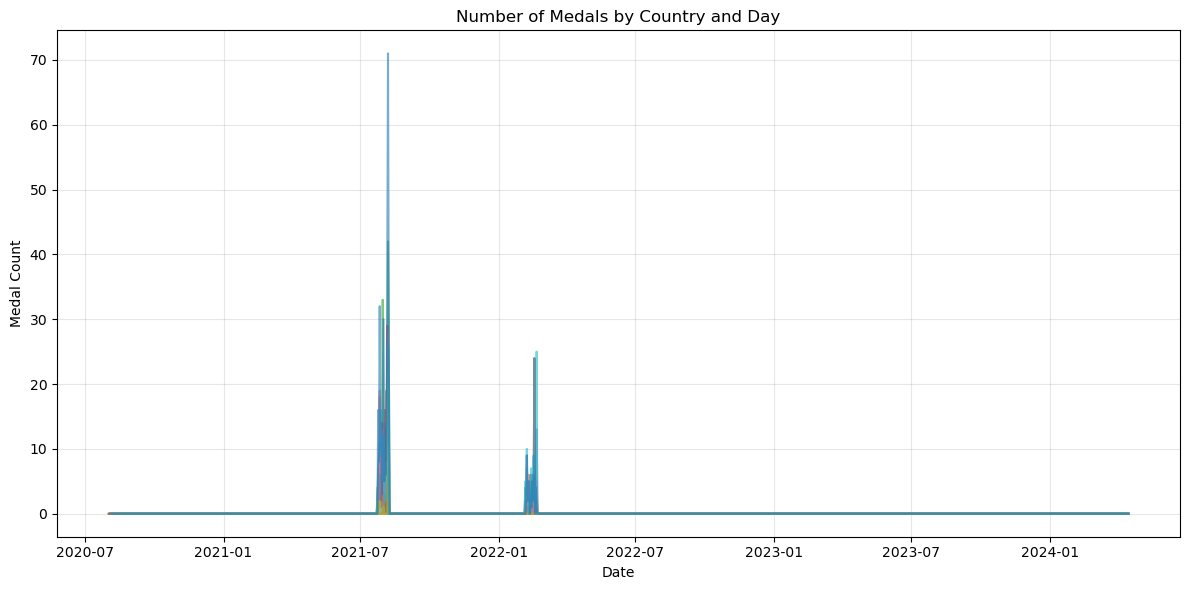

In [43]:
plt.figure(figsize=(12, 6))

for country, group_df in data_grouped.groupby("country_code_iso3"):
    plt.plot(group_df["date_clean"], group_df["medal_count"], alpha=0.6)

plt.title("Number of Medals by Country and Day")
plt.xlabel("Date")
plt.ylabel("Medal Count")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [44]:
data_grouped['sports_videos'].var(), data_grouped['sports_videos'].mean()

(93.4329338789921, 13.014823798935382)

Variance(y) >> Mean(y)
Thus, the data are overdispersed and negative binomial is more appropriate than Poisson

I tried to estimate alpha in E(Y|X) = mu + alpha*mu^2 using discrete NB but it didn't work, probably due to having too many fixed effects. Thus, I am using an implementaiton where alpha = 1 with robust SEs.

Base Model

In [45]:
model = smf.glm(
    formula="sports_videos ~ olympic_period + C(country_code_iso3) + date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          sports_videos   No. Observations:                14841
Model:                            GLM   Df Residuals:                    14817
Model Family:        NegativeBinomial   Df Model:                           23
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51297.
Date:                Sun, 14 Dec 2025   Deviance:                       1650.5
Time:                        17:15:45   Pearson chi2:                 1.44e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.07682
Covariance Type:                  HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [46]:
data_grouped['country_code_iso3'].unique() #Brazil is the reference group

array(['BRA', 'CAN', 'GER', 'FRA', 'GBR', 'IND', 'JPN', 'KOR', 'MEX',
       'RUS', 'USA'], dtype=object)

Is time trend different by country?

In [47]:
model = smf.glm(
    formula="sports_videos ~ olympic_period + C(country_code_iso3) * date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")
print(model.summary())

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:          sports_videos   No. Observations:                14841
Model:                            GLM   Df Residuals:                    14807
Model Family:        NegativeBinomial   Df Model:                           33
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51290.
Date:                Sun, 14 Dec 2025   Deviance:                       1636.7
Time:                        17:15:46   Pearson chi2:                 1.44e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.07768
Covariance Type:                  HC3                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Are summer and winter olympic effects different?

In [48]:
model = smf.glm(
    formula="sports_videos ~ summer_during + winter_during + C(country_code_iso3) * date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")
print(model.summary())
#Yes, summer effect is larger

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:          sports_videos   No. Observations:                14841
Model:                            GLM   Df Residuals:                    14806
Model Family:        NegativeBinomial   Df Model:                           34
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51290.
Date:                Sun, 14 Dec 2025   Deviance:                       1636.4
Time:                        17:15:47   Pearson chi2:                 1.44e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.07770
Covariance Type:                  HC3                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Are Olympic Period effects different by country?

In [49]:
model = smf.glm(
    formula="sports_videos ~ C(country_code_iso3) * winter_during + C(country_code_iso3) * summer_during + C(country_code_iso3) * date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")
print(model.summary())
#There is quite strong heterogeneity in summer/winter olympic effects between countries

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:          sports_videos   No. Observations:                14841
Model:                            GLM   Df Residuals:                    14786
Model Family:        NegativeBinomial   Df Model:                           54
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51288.
Date:                Sun, 14 Dec 2025   Deviance:                       1633.3
Time:                        17:15:48   Pearson chi2:                 1.43e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.07789
Covariance Type:                  HC3                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Is medal count or medal score a better predictor?

In [ ]:
model = smf.glm(
    formula="sports_videos ~ medal_count + C(country_code_iso3) * winter_during + C(country_code_iso3) * summer_during + C(country_code_iso3) * date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")

coef_medal_count = model.params["medal_count"]
se_medal_count   = model.bse["medal_count"]

model = smf.glm(
    formula="sports_videos ~ medal_score + C(country_code_iso3) * winter_during + C(country_code_iso3) * summer_during + C(country_code_iso3) * date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")

coef_medal_score = model.params["medal_score"]
se_medal_score   = model.bse["medal_score"]

print("Medal Count:", coef_medal_count, "SE:", se_medal_count)
print("Medal Score:", coef_medal_score, "SE:", se_medal_score)
#Neither is significant, proceeding with medal count because it is simpler and medal weights are somewhat arbitrary

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Medal Count: 0.0030211403905488856 SE: 0.0025368635794259095
Medal Score: 0.0015837774762245491 SE: 0.0009730206791588944


What about lagged medal count?

In [ ]:
data_grouped = data_grouped.sort_values(["country_code", "date_clean"])

for l in range(1, 8):  # 1 to 7
    data_grouped[f"medal_count_lag{l}"] = (
        data_grouped.groupby("country_code")["medal_count"].shift(l)
    )

lag_cols = [f"medal_count_lag{l}" for l in range(1, 8)]
data_grouped[lag_cols] = data_grouped[lag_cols].fillna(0)

for t in range(1, 22): # 1 (medal_count) to 21
    data_grouped[f"rolling_medals_{t}"] = (
        data_grouped.groupby("country_code")["medal_count"]
        .rolling(t, min_periods=1)
        .sum()
        .reset_index(0, drop=True)
    )
#rolling sum

In [52]:
data_grouped[[f"rolling_medals_{t}" for t in range(1, 22)]].isna().sum()
#no NAs

rolling_medals_1     0
rolling_medals_2     0
rolling_medals_3     0
rolling_medals_4     0
rolling_medals_5     0
rolling_medals_6     0
rolling_medals_7     0
rolling_medals_8     0
rolling_medals_9     0
rolling_medals_10    0
rolling_medals_11    0
rolling_medals_12    0
rolling_medals_13    0
rolling_medals_14    0
rolling_medals_15    0
rolling_medals_16    0
rolling_medals_17    0
rolling_medals_18    0
rolling_medals_19    0
rolling_medals_20    0
rolling_medals_21    0
dtype: int64

In [61]:
results = []

for t in range(1, 22):
    var = f"rolling_medals_{t}"
    
    formula = (
        f"sports_videos ~ {var} + summer_week_minus_1 + summer_during + summer_week_plus_1 + summer_week_plus_2 + summer_week_plus_3 + winter_week_minus_1 + winter_during + winter_week_plus_1 + winter_week_plus_2 + winter_week_plus_3 + C(country_code_iso3) * date_num + C(month)"
    )
    
    model = smf.glm( #run the model with country FE, country-specific time trend, seasonality, Olympic dummies, and a rolling sum of medals
        formula=formula,
        data=data_grouped,
        family=sm.families.NegativeBinomial(),
        offset=np.log(data_grouped["videos"])
    ).fit(cov_type="HC3")
    
    z_val = model.tvalues[var]
    coef  = model.params[var]
    
    results.append({
        "rolling_window": t,
        "coef": coef,
        "z_value": z_val
    })

z_df = pd.DataFrame(results)

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alp

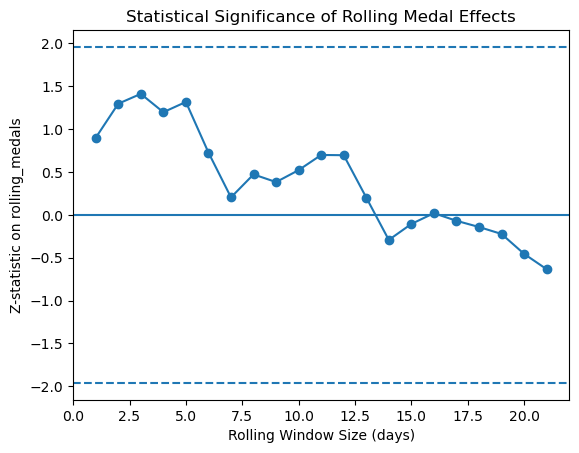

In [54]:
plt.figure()
plt.plot(z_df["rolling_window"], z_df["z_value"], marker="o")
plt.axhline(0)
plt.axhline(1.96, linestyle="--")
plt.axhline(-1.96, linestyle="--")

plt.xlabel("Rolling Window Size (days)")
plt.ylabel("Z-statistic on rolling_medals")
plt.title("Statistical Significance of Rolling Medal Effects")

plt.show()


In [55]:
print(z_df)

    rolling_window      coef   z_value
0                1  0.002084  0.899874
1                2  0.001459  1.297619
2                3  0.001106  1.412327
3                4  0.000760  1.198560
4                5  0.000734  1.318063
5                6  0.000372  0.727992
6                7  0.000095  0.204693
7                8  0.000206  0.472784
8                9  0.000152  0.383144
9               10  0.000188  0.522679
10              11  0.000229  0.699490
11              12  0.000214  0.696711
12              13  0.000060  0.202750
13              14 -0.000084 -0.291881
14              15 -0.000029 -0.105349
15              16  0.000005  0.020204
16              17 -0.000018 -0.068437
17              18 -0.000036 -0.140840
18              19 -0.000056 -0.222082
19              20 -0.000113 -0.454262
20              21 -0.000153 -0.633180


Pre and Post medal effects

In [56]:
model = smf.glm(
    formula="sports_videos ~ summer_week_minus_1 + summer_during + summer_week_plus_1 + summer_week_plus_2 + summer_week_plus_3 + winter_week_minus_1 + winter_during + winter_week_plus_1 + winter_week_plus_2 + winter_week_plus_3 + medal_count + C(country_code_iso3) * date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")
print(model.summary())

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:          sports_videos   No. Observations:                14841
Model:                            GLM   Df Residuals:                    14797
Model Family:        NegativeBinomial   Df Model:                           43
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51289.
Date:                Sun, 14 Dec 2025   Deviance:                       1635.1
Time:                        17:16:03   Pearson chi2:                 1.43e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.07778
Covariance Type:                  HC3                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Estimating effect sizes in terms absolute number of videos

In [62]:
median_sports_pct = data_grouped.groupby('country_code_iso3').agg({
              'videos': 'mean',
              'sports_videos': 'mean',
              'sports_pct': 'median'
          }).reset_index()

In [63]:
median_sports_pct

,country_code_iso3,videos,sports_videos,sports_pct
0,BRA,29.286138,12.089696,0.418605
1,CAN,37.712380,11.782802,0.307692
2,FRA,40.125926,15.118519,0.379049
3,GBR,35.290586,12.461824,0.346154
4,GER,41.123795,14.516679,0.357143
5,IND,58.361214,7.153220,0.117647
6,JPN,23.774815,9.635556,0.406250
7,KOR,20.942179,6.453669,0.304348
8,MEX,24.030370,7.708148,0.322581
9,RUS,97.588104,36.352416,0.370079


Graph for presentation

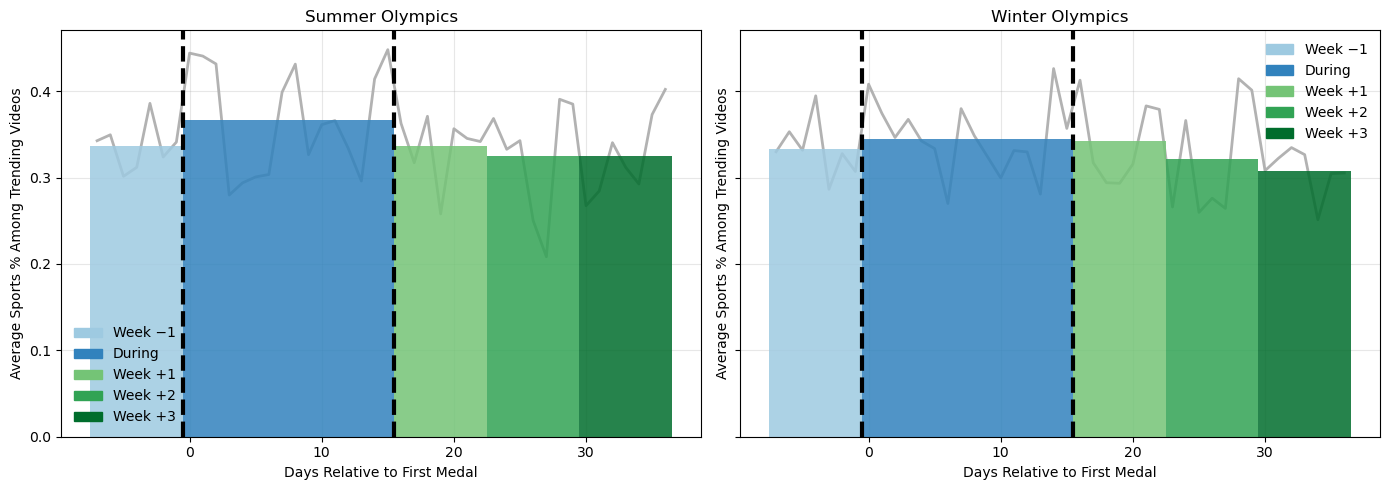

In [59]:
def plot_olympics_bars_and_line(
    df,
    event_time_col,
    start_date,
    end_date,
    title,
    ax
):
    """
    df: data_grouped
    event_time_col: 'event_time_summer' or 'event_time_winter'
    start_date, end_date: first and last medal dates
    ax: matplotlib axis
    """

    olympic_length = (end_date - start_date).days

    # Keep only days that belong to a bar window
    mask = df[event_time_col].between(-7, olympic_length + 21)
    df = df.loc[mask].copy()

    # ---- Gray line: daily average across countries ----
    daily_avg = (
        df.groupby(event_time_col)["sports_pct"]
          .mean()
          .reset_index()
    )

    ax.plot(
        daily_avg[event_time_col],
        daily_avg["sports_pct"],
        color="gray",
        alpha=0.6,
        linewidth=2,
        zorder=1
    )

    # ---- Define bar windows (in event time) ----
    windows = {
        "Week −1": (-7, -1),
        "During": (0, olympic_length),
        "Week +1": (olympic_length + 1, olympic_length + 7),
        "Week +2": (olympic_length + 8, olympic_length + 14),
        "Week +3": (olympic_length + 15, olympic_length + 21),
    }

    bar_colors_map = {
        "Week −1": "#9ecae1",   # light blue
        "During": "#3182bd",   # dark blue
        "Week +1": "#74c476",  # light green
        "Week +2": "#31a354",  # medium green
        "Week +3": "#006d2c",  # dark green
    }

    bar_centers = []
    bar_heights = []
    bar_widths = []
    bar_colors = []

    for label, (lo, hi) in windows.items():
        window_mean = df.loc[
            df[event_time_col].between(lo, hi),
            "sports_pct"
        ].mean()

        bar_centers.append((lo + hi) / 2)
        bar_heights.append(window_mean)
        bar_widths.append(hi - lo + 1)
        bar_colors.append(bar_colors_map[label])

    # ---- Bars ----
    ax.bar(
        bar_centers,
        bar_heights,
        width=bar_widths,
        color=bar_colors,
        alpha=0.85,
        zorder=2
    )

    # ---- Mark first and last medal ----
    ax.axvline(-0.5, linestyle="--", linewidth=3, color = "black")
    ax.axvline(olympic_length+0.5, linestyle="--", linewidth=3, color = "black")

    ax.set_title(title)
    ax.set_xlabel("Days Relative to First Medal")
    ax.set_ylabel("Average Sports % Among Trending Videos")
    ax.grid(True, alpha=0.3)

    legend_handles = [
        Patch(color=color, label=label)
        for label, color in bar_colors_map.items()
    ]

    ax.legend(handles=legend_handles, frameon=False)


data_grouped["event_time_summer"] = (
    data_grouped["date_clean"] - summer_min
).dt.days

data_grouped["event_time_winter"] = (
    data_grouped["date_clean"] - winter_min
).dt.days

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

plot_olympics_bars_and_line(
    df=data_grouped,
    event_time_col="event_time_summer",
    start_date=summer_min,
    end_date=summer_max,
    title="Summer Olympics",
    ax=axes[0]
)

plot_olympics_bars_and_line(
    df=data_grouped,
    event_time_col="event_time_winter",
    start_date=winter_min,
    end_date=winter_max,
    title="Winter Olympics",
    ax=axes[1]
)

plt.tight_layout()
plt.show()